In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, suppress=True)
import time
from pbdlib import plot_gmm
from scipy.special import digamma
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvn
from scipy.stats import t
from scipy.special import loggamma
from sklearn.metrics import mean_squared_error as mse
from IPython.display import clear_output

In [169]:
sess = tf.InteractiveSession()

In [2]:
from math import *

def t_logpdf(x,df,mu,Sigma):
    '''
    Multivariate t-student density:
    output:
        the density of the given element
    input:
        x = parameter (d dimensional numpy array or scalar)
        mu = mean (d dimensional numpy array or scalar)
        Sigma = scale matrix (dxd numpy array)
        df = degrees of freedom
        d: dimension
    '''
    d = x.shape[0]
    Num = loggamma(1. * (d+df)/2)
    Denom =  loggamma(1.*df/2) + 0.5*d*np.log(df*pi)   + 0.5*np.log(np.linalg.det(Sigma)) + \
            (0.5*(d+df))*np.log(1 + (1./df)*np.dot(np.dot((x - mu),np.linalg.inv(Sigma)), (x - mu)))
    d = Num - Denom  
    return d

In [3]:
def calc_MSLL(y_pred, y_cov, y_true, train_mean, train_var): #calculate Mean Standardized Log Loss
    n = y_pred.shape[0]
    MSLL = 0
    for i in range(n):
        SLL_trivial = 0.5*np.log(2*np.pi*train_var) + ((train_mean-y_true[i])**2)/(2*train_var)
        MSLL += 0.5*np.log(2*np.pi*y_cov[i]) + ((y_pred[i]-y_true[i])**2)/(2*y_cov[0]) - SLL_trivial
    MSLL /= n
    return MSLL

In [4]:
def log_normalize(x):
    return x - logsumexp(x)

In [5]:
def filter_gaussian(means_, covariances_, weights_, threshold = 0.01):
    means = [] 
    covs = []
    for i,w in enumerate(weights_):
        if w > threshold:
            means.append(means_[i])
            covs.append(covariances_[i])
    
    means = np.array(means)
    covs = np.array(covs)
    return means,covs

### Define class for GMM and GMR

In [73]:
from sklearn.cluster import KMeans
class GMM():
    def __init__(self, n_comp = 10, D = 1, K = 2, weight_concentration = 0.1):
        self.n_comp = n_comp
        self.D = D
        self.K = K

        #pi params
        self.alpha0 = np.ones(K)*weight_concentration
        self.alpha = np.copy(self.alpha0)

        #mu and sigma params
        self.betha0 = 0.0001
        self.betha = np.ones(self.K)
        self.mu0 = np.zeros(self.D)
        self.v0 = self.D
        self.W0 = np.eye(self.D)/(self.v0)
        #
        self.W = [np.eye(self.D) for i in range(self.K)]
        self.v = np.ones(self.K)*self.D
        
        self.reg_covar = 1e-06
        
    def fit(self,x, num_iter = 10,restart=True, stochastic=True, batch_size = 2000):
        self.x = x
        self.stochastic = stochastic
        self.batch_size = batch_size
        cov = np.cov(x.T)
        if restart:
            kMM = KMeans(n_clusters=self.K).fit(x)
            self.mu = kMM.cluster_centers_
            #self.mu = x[np.random.choice(len(x),size = self.K)]
        for i in range(num_iter):
            print 'Iteration ' + str(i)
            self.expectation()
            #print self.ro, self.xks, self.Nks
            self.maximization()
            #print self.betha, self.v, self.W
            
        self.sigma = []
        for k in range(self.K):
            sigma = np.linalg.inv(self.v[k]*self.W[k])
            self.sigma.append(sigma)

        self.weights = self.alpha/np.sum(self.alpha)


    def expectation(self):
        if self.stochastic:
            indexes = np.arange(0, len(self.x),1)
            np.random.shuffle(indexes)
            indexes = indexes[0:self.batch_size]
            data = self.x[indexes]
            N = self.batch_size
        else:
            data = self.x
            N = data.shape[0]
            
        self.ln_ro = np.zeros([N,self.K])
        self.ro = np.zeros([N,self.K])
        
        print 'Calculating ro'
        tic = time.time()
        for k in range(self.K):
            E_s = self.D*np.log(2) + np.log(np.linalg.det(self.W[k])) + np.sum([digamma((self.v[k] + 1 - i)/2.) \
                                                                           for i in range(self.D)])
            E_pi = digamma(self.alpha[k]) - digamma(np.sum(self.alpha))
            E_2 = self.D*np.log(2*np.pi)
            for n in range(data.shape[0]):
                E_ms = self.D/self.betha[k] + self.v[k]*np.dot(data[n] - self.mu[k], np.dot(self.W[k], \
                                                                                data[n] - self.mu[k]))
                self.ln_ro[n,k] = E_pi + 0.5*E_s - 0.5*E_2 - 0.5*E_ms

        for n in range(N):        
            self.ln_ro[n,:] = log_normalize(self.ln_ro[n,:])
            self.ro[n,:] = np.exp(self.ln_ro[n,:])
        toc = time.time()
        print toc-tic


        self.Nks = np.array([1e-6 + np.sum(self.ro[:,k]) for k in range(self.K)])

        self.xks = np.dot(self.ro.T, data)
        for k in range(self.K):
            self.xks[k,:] /= self.Nks[k]


        print 'Calculating Sk' 
        self.Sks = []
        for k in range(self.K):
            Sk = np.zeros([self.D,self.D])
            for n in range(N):
                Sk += self.ro[n,k]*np.outer(data[n]-self.xks[k], data[n]-self.xks[k])
            Sk /= self.Nks[k]
            self.Sks.append(Sk)

        toc = time.time()
        print toc-tic

             
    def maximization(self):
        self.alpha = self.alpha0 + self.Nks
        self.betha = self.betha0 + self.Nks

        for k in range(self.K):
            self.mu[k] = (self.betha0*self.mu0 + self.Nks[k]*self.xks[k])/self.betha[k]
            Wk_inv = np.linalg.inv(self.W0 + self.reg_covar*np.eye(self.D)) + self.Nks[k]*self.Sks[k] + np.outer(self.xks[k]-self.mu0, \
                                    self.xks[k]-self.mu0)*self.betha0*self.Nks[k]/(self.betha0+self.Nks[k])
            self.W[k] = np.linalg.inv(Wk_inv+ self.reg_covar*np.eye(self.D))
            self.v[k] = self.v0 + self.Nks[k]
            
    def plot(self):
        fig,ax = plt.subplots()
        plot_gaussian(self.mu, self.sigma, ax, self.weights )


In [7]:
class BGMR():
    def __init__(self, GMM, n_in, n_out):
        self.GMM = GMM
        self.n_in = n_in
        self.n_out = n_out
        #segment the gaussian components
        self.mu_x = []
        self.mu_y = []
        self.sigma_xx = []
        self.sigma_yy = []
        self.sigma_xy = []

        
        for k in range(self.GMM.K):
            self.mu_x.append(self.GMM.mu[k][0:self.n_in])        
            self.mu_y.append(self.GMM.mu[k][self.n_in:])        
            self.sigma_xx.append(self.GMM.sigma[k][0:self.n_in, 0:self.n_in])        
            self.sigma_yy.append(self.GMM.sigma[k][self.n_in:, self.n_in:])        
            self.sigma_xy.append(self.GMM.sigma[k][0:self.n_in, self.n_in:])
            
        self.mu_x = np.array(self.mu_x)
        self.mu_y = np.array(self.mu_y)
        self.sigma_xx = np.array(self.sigma_xx)
        self.sigma_yy = np.array(self.sigma_yy)
        self.sigma_xy = np.array(self.sigma_xy)
        
        self.vy_x = self.GMM.v + self.n_in
        
        
    def predict(self,x):
        h = []
        mu = []        
        sigma = []

        for k in range(self.GMM.K):
            h.append(np.log(self.GMM.weights[k])+ t_logpdf(x, self.GMM.v[k], self.mu_x[k],self.sigma_xx[k]))
            mu.append(self.mu_y[k] + np.dot(self.sigma_xy[k].T, \
                                            np.dot(np.linalg.inv(self.sigma_xx[k]), x - self.mu_x[k])))
            sigma.append( (self.GMM.v[k] + np.dot(x-self.mu_x[k], np.dot(np.linalg.inv(self.sigma_xx[k]), x-self.mu_x[k]))) \
            *(self.sigma_yy[k]- np.dot(self.sigma_xy[k].T, np.dot(np.linalg.inv(self.sigma_xx[k]), self.sigma_xy[k]))) \
            / self.vy_x[k])
              
        h = np.array(h)
        h = np.exp(log_normalize(h))
        #h = h/np.sum(h)
        mu = np.array(mu)
        #print h,mu
        #print h.shape,mu.shape
        sigma_one = np.zeros([self.n_out, self.n_out])
        mu_one = np.zeros(self.n_out)
        for k in range(self.GMM.K):
            sigma_one += h[k]*(sigma[k] + np.outer(mu[k],mu[k]))
            mu_one += h[k]*mu[k]
            
        sigma_one -= np.outer(mu_one, mu_one)
        return mu_one, sigma_one

In [8]:
class GMR():
    def __init__(self, GMM, n_in, n_out):
        self.GMM = GMM
        self.n_in = n_in
        self.n_out = n_out
        #segment the gaussian components
        self.mu_x = []
        self.mu_y = []
        self.sigma_xx = []
        self.sigma_yy = []
        self.sigma_xy = []
        self.sigma_xyx = []
        for k in range(self.GMM.K):
            self.mu_x.append(self.GMM.mu[k][0:self.n_in])        
            self.mu_y.append(self.GMM.mu[k][self.n_in:])        
            self.sigma_xx.append(self.GMM.sigma[k][0:self.n_in, 0:self.n_in])        
            self.sigma_yy.append(self.GMM.sigma[k][self.n_in:, self.n_in:])        
            self.sigma_xy.append(self.GMM.sigma[k][0:self.n_in, self.n_in:])
            self.sigma_xyx.append(np.dot(self.sigma_xy[k].T,np.linalg.inv(self.sigma_xx[k])))
            
        self.mu_x = np.array(self.mu_x)
        self.mu_y = np.array(self.mu_y)
        self.sigma_xx = np.array(self.sigma_xx)
        self.sigma_yy = np.array(self.sigma_yy)
        self.sigma_xy = np.array(self.sigma_xy)
        self.sigma =[self.sigma_yy[k]- np.dot(self.sigma_xy[k].T, \
            np.dot(np.linalg.inv(self.sigma_xx[k]), self.sigma_xy[k])) for k in range(self.GMM.K)]
        
    def predict(self,x):
        h = []
        mu = []        

        for k in range(self.GMM.K):
            h.append(self.GMM.weights[k]*mvn(mean = self.mu_x[k], cov = self.sigma_xx[k]).pdf(x))
            mu.append(self.mu_y[k] + np.dot(self.sigma_xyx[k], x - self.mu_x[k]))
        
        h = np.array(h)
        h = h/np.sum(h)
        mu = np.array(mu)
        sigma = self.sigma
        
        sigma_one = np.zeros([self.n_out, self.n_out])
        mu_one = np.zeros(self.n_out)
        for k in range(self.GMM.K):
            sigma_one += h[k]*(sigma[k] + np.outer(mu[k],mu[k]))
            mu_one += h[k]*mu[k]
            
        sigma_one -= np.outer(mu_one, mu_one)
        return mu_one, sigma_one

###  Try GMM with Data

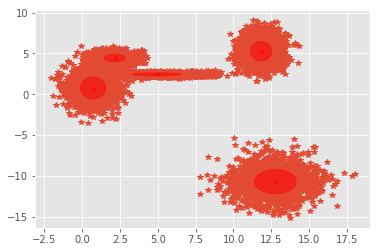

In [67]:
import numpy as np
import matplotlib.pyplot as plt
D = 2
K_true = 5
N = 10000
is_plot = True

mus_true = []
sigmas_true = []
samples = []
for k in range(K_true):
    mu = 5*np.random.normal(size=D)
    sigma = 3*np.diag(np.random.rand(D))
    sample = np.random.multivariate_normal(mu, cov = sigma, size = N/K_true)
    mus_true.append(mu)
    sigmas_true.append(sigma)
    samples.append(sample)
    
x = np.vstack(samples)
mus_true = np.array(mus_true)
sigmas_true = np.array(sigmas_true)

if is_plot:
    fig,ax = plt.subplots()
    plot_gmm(mus_true,sigmas_true)#,ax)
    plt.plot(x[:,0],x[:,1],'*',zorder = 1)

In [ ]:
gmm = GMM(D = 2, K = 5, weight_concentration=0.01)
gmm.fit(x,num_iter = 50,stochastic=True,batch_size=1000)

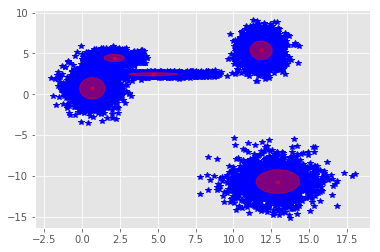

In [72]:
fig,ax = plt.subplots()
means, covs = filter_gaussian(gmm.mu, gmm.sigma, gmm.weights,threshold=0.05)
plot_gmm(means,covs)
plt.plot(x[:,0], x[:,1], '*b',zorder=1)
plt.show()

### Try GMR on Data 

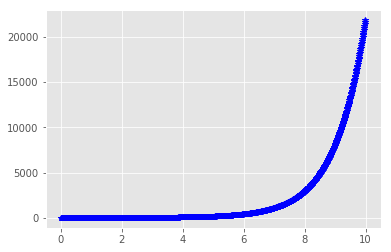

In [78]:
x_in = np.concatenate([np.arange(0,5,0.01), np.arange(5,10,0.01)])
#x_out = np.sin(2*x_in) + np.random.rand(len(x_in))*1
x_out = np.exp(x_in) + np.random.rand(len(x_in))*1

x = np.vstack([x_in, x_out]).T
plt.plot(x[:,0],x[:,1],'*b',zorder=1)

In [79]:
gmm = GMM(n_comp=10, D=2,K=30,weight_concentration=1)

In [ ]:
gmm.fit(x,num_iter = 30,restart=True)

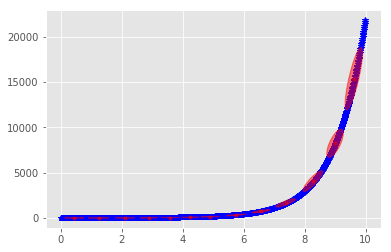

In [81]:
means, covs = filter_gaussian(gmm.mu, gmm.sigma, gmm.weights,threshold=0.01)
plot_gmm(means,covs)
plt.plot(x[:,0],x[:,1],'*b',zorder=1)
plt.show()

In [82]:
gmr = BGMR(gmm, 1, 1)

y_pred = []
y_cov = []
x_test = np.arange(-3,11,0.05)
for x_i in x_test:
    m, cov = (gmr.predict(np.array([x_i])))
    y_pred.append(m)
    y_cov.append(cov)
       
y_pred = np.array(y_pred)
y_cov = np.array(y_cov)

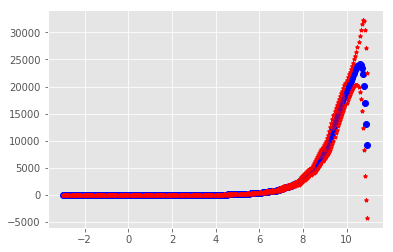

In [83]:
plt.plot(x_test, y_pred,'ob')
plt.plot(x_test, y_pred[:,0]+np.sqrt(y_cov[:,0,0]),'*r',markersize=4)
plt.plot(x_test,  y_pred[:,0]- np.sqrt(y_cov[:,0,0]),'*r',markersize=4)  
plot_gmm(means,covs)
plt.show()

### SARCOS Inverse Dynamics

In [74]:
from scipy.io import loadmat
data_train = loadmat('data/sarcos_inv.mat')
data_test = loadmat('data/sarcos_inv_test.mat')

x_train = data_train['sarcos_inv'][:,:21]
y_train = data_train['sarcos_inv'][:,21:22]
y_var = np.var(y_train)

x_test = data_test['sarcos_inv_test'][:,:21]
y_test = data_test['sarcos_inv_test'][:,21:22]

X  = np.hstack([np.ones((x_train.shape[0],1)), x_train])
Y = y_train.copy()

X_test = np.hstack([np.ones((x_test.shape[0],1)), x_test])
Y_test = y_test.copy()

#### Subsample data

In [75]:
data_train = np.hstack([X,Y])
data_test = np.hstack([X_test,Y_test])
print data_train.shape

(44484, 23)


In [132]:
indexes = np.arange(0, len(data_train),1)
np.random.shuffle(indexes)
indexes = indexes[0:2000]
data_train = data_train[indexes]

#### Learning the joint distribution of X and Y as GMM

In [115]:
gmm = GMM(K=100, D=data_train.shape[1],weight_concentration=0.01)

In [116]:
gmm.fit(data_train,num_iter=50, stochastic=False, batch_size=20000,restart=True)

Iteration 0
Calculating ro
28.4104588032
Calculating Sk
64.6625609398
Iteration 1
Calculating ro
25.6938941479
Calculating Sk
61.1424560547
Iteration 2
Calculating ro
25.7111501694
Calculating Sk
60.9190130234
Iteration 3
Calculating ro
26.0123040676
Calculating Sk
68.1863520145
Iteration 4
Calculating ro
25.8650228977
Calculating Sk
61.073693037
Iteration 5
Calculating ro
29.1804349422
Calculating Sk
64.2750971317
Iteration 6
Calculating ro
26.6254060268
Calculating Sk
70.9121909142
Iteration 7
Calculating ro
29.240721941
Calculating Sk
77.310256958
Iteration 8
Calculating ro
28.2338118553
Calculating Sk
63.4259839058
Iteration 9
Calculating ro
25.6165709496
Calculating Sk
61.115623951
Iteration 10
Calculating ro
25.7856199741
Calculating Sk
70.6583628654
Iteration 11
Calculating ro
26.591490984
Calculating Sk
65.2007269859
Iteration 12
Calculating ro
27.7230119705
Calculating Sk
72.189896822
Iteration 13
Calculating ro
28.3502819538
Calculating Sk
65.7394490242
Iteration 14
Calculati

#### Evaluate

In [151]:
gmr = BGMR(gmm, n_in=22,n_out=1)

In [126]:
#calculate training error
pred_train = []
cov_train = []
true_val_train = []
for i in range(data_train.shape[0]):
    print i
    y_pred, y_cov = gmr.predict(X[i])
    pred_train.append(y_pred)
    cov_train.append(y_cov)
    true_val_train.append(X[i])
    clear_output(wait=True)
    
pred_train = np.array(pred_train)

44483


In [152]:
#calculate test error
pred_test = []
cov_test = []
true_val_test = []
for i in range(X_test.shape[0]):
    print i
    y_pred, y_cov = gmr.predict(X_test[i])
    pred_test.append(y_pred)
    cov_test.append(y_cov)
    true_val_test.append(Y_test[i])
    clear_output(wait=True)
    
pred_test = np.array(pred_test)

4448


#### Calculate Standard Mean Square Error (SMSE)

In [154]:
smse_train_ = mse(pred_train,Y)/y_var
print 'SMSE training is ' + str(smse_train_)

SMSE training is 0.038599196554095945


In [155]:
smse_test = mse(pred_test,Y_test)/y_var
print 'SMSE test is ' + str(smse_test)

SMSE test is 0.03825339729970163


#### Calculate Mean Standard Log Loss (MSLL)

In [156]:
train_mean = np.mean(y_train)
train_var = np.var(y_train)

In [158]:
msll_train_ = calc_MSLL(pred_train, cov_train, Y, train_mean, train_var)
msll_test = calc_MSLL(pred_test, cov_test, Y_test, train_mean, train_var)
print 'MSLL training is ' + str(msll_train_)
print 'MSLL test is ' + str(msll_test)

MSLL training is [[-1.73]]
MSLL test is [[-1.73]]
